<a href="https://colab.research.google.com/github/MohammedTaha-751/FUTURE_ML_2/blob/main/Churn_Prediction_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

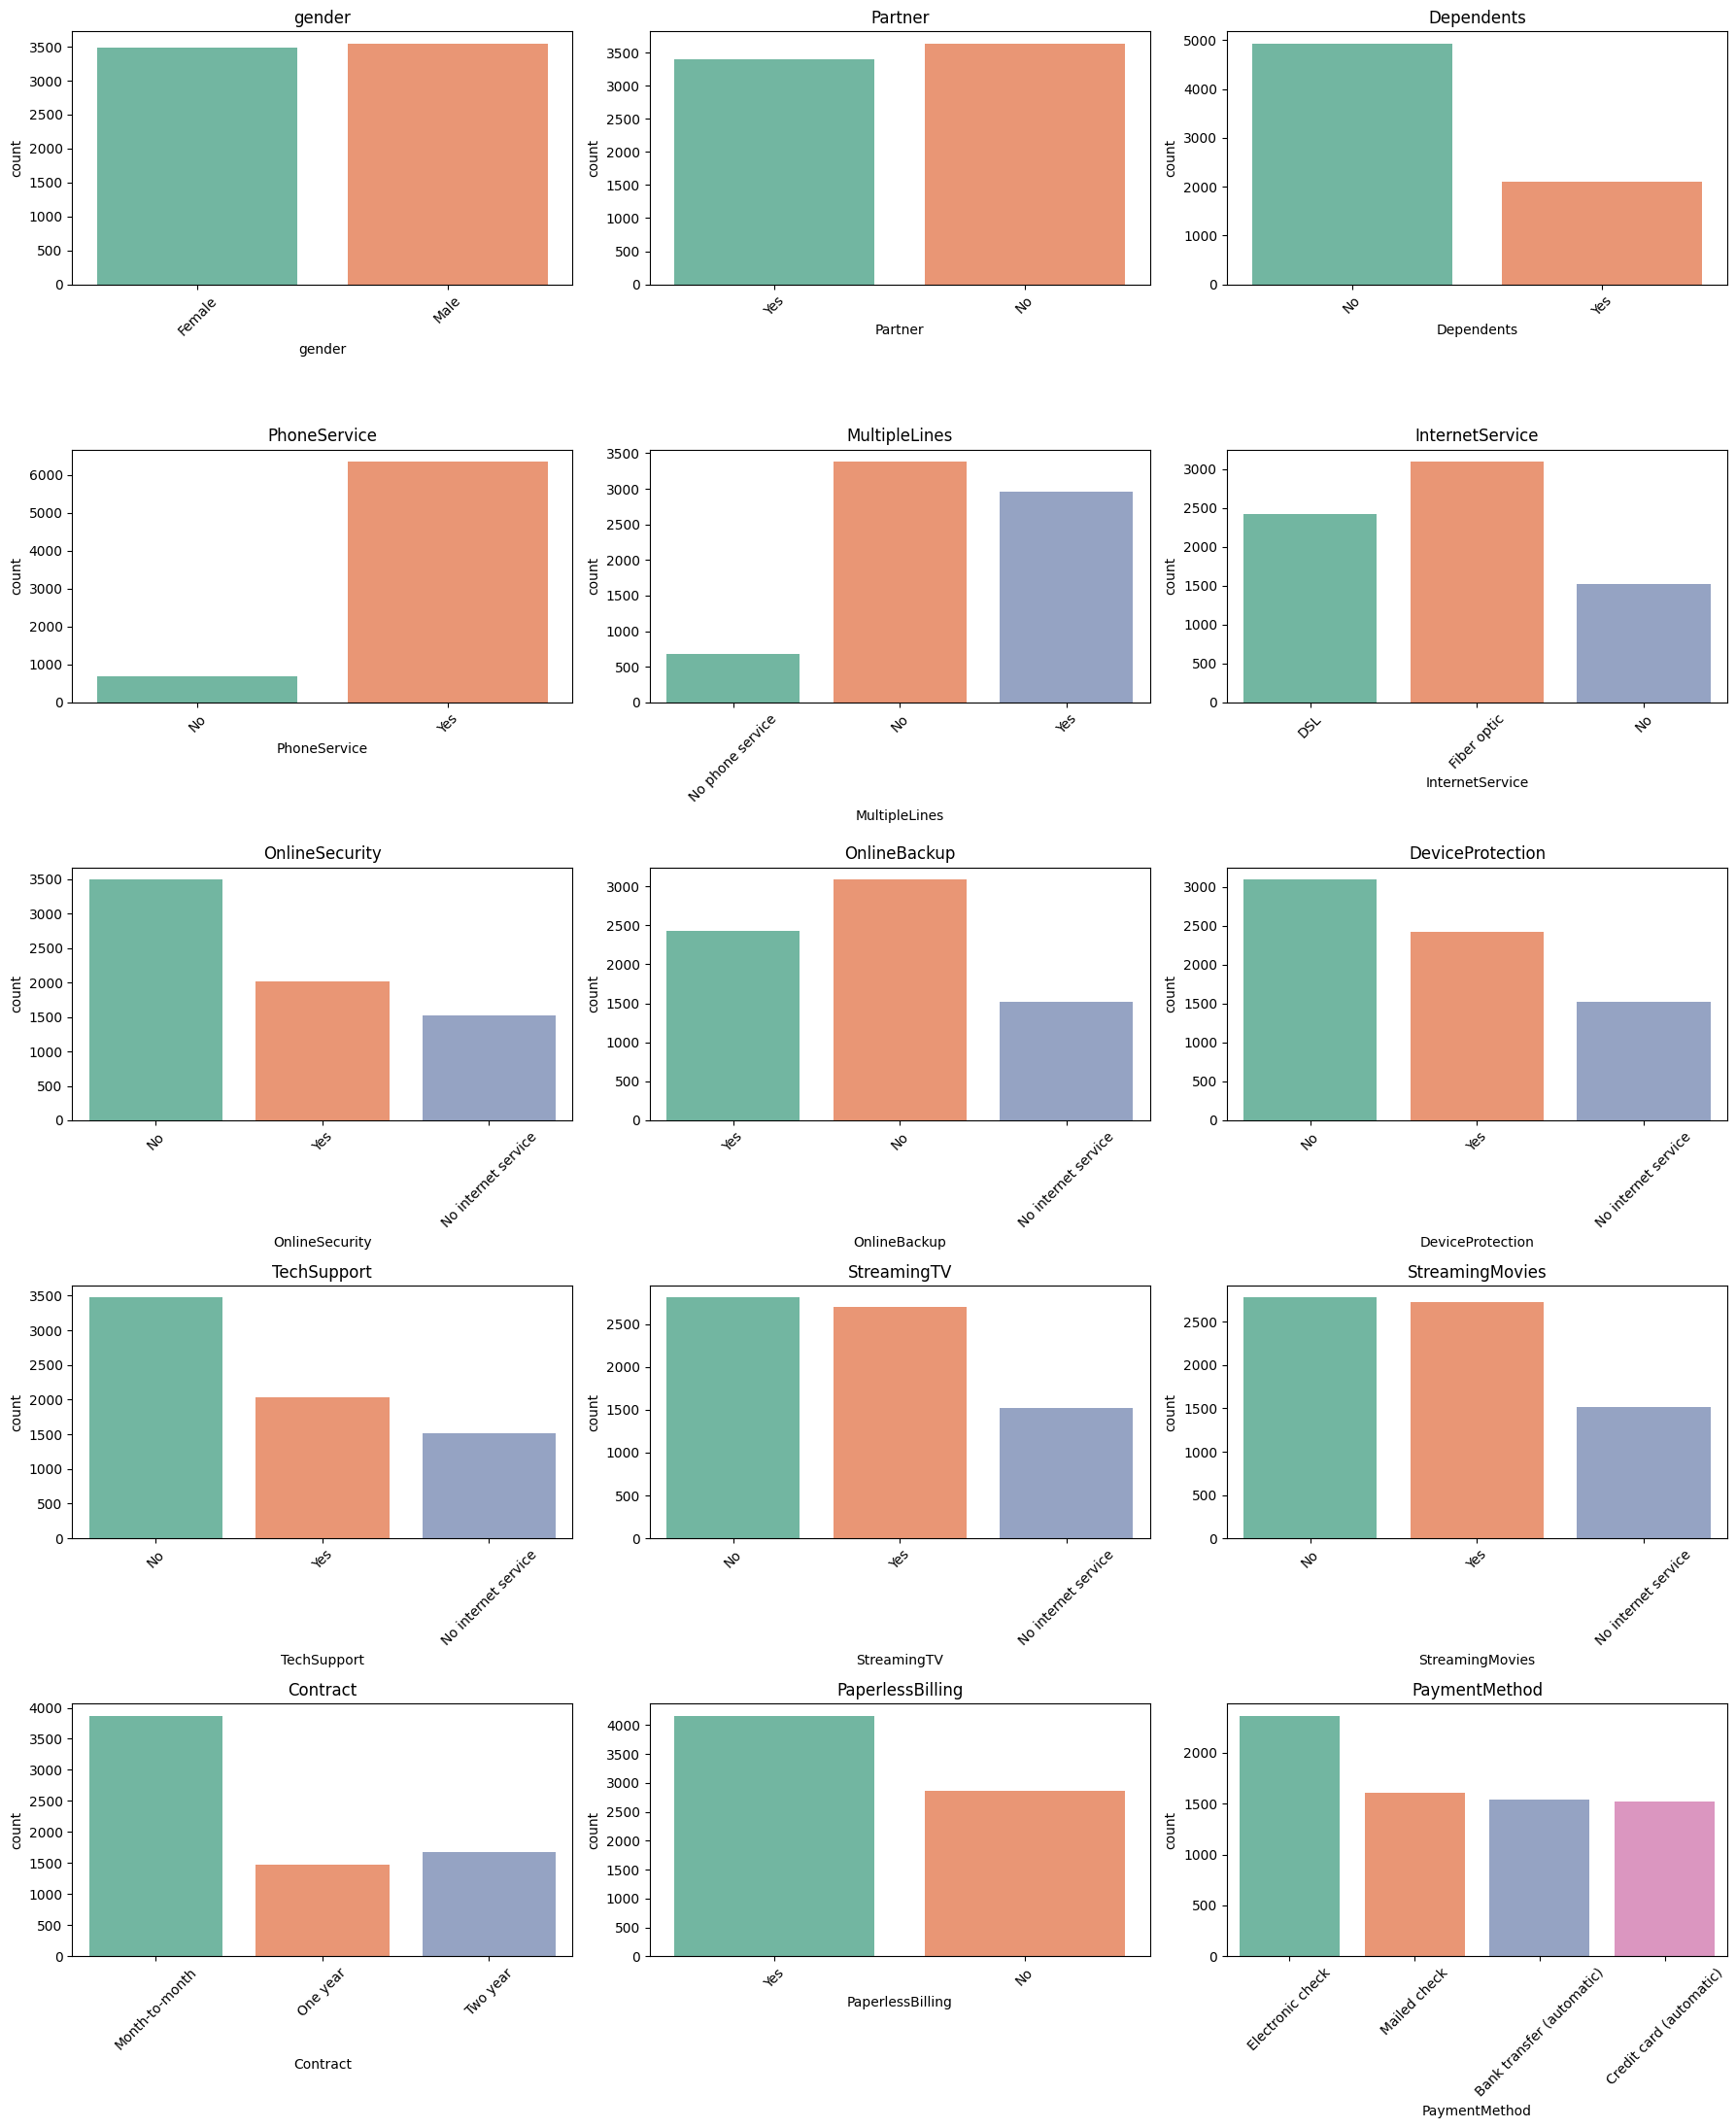

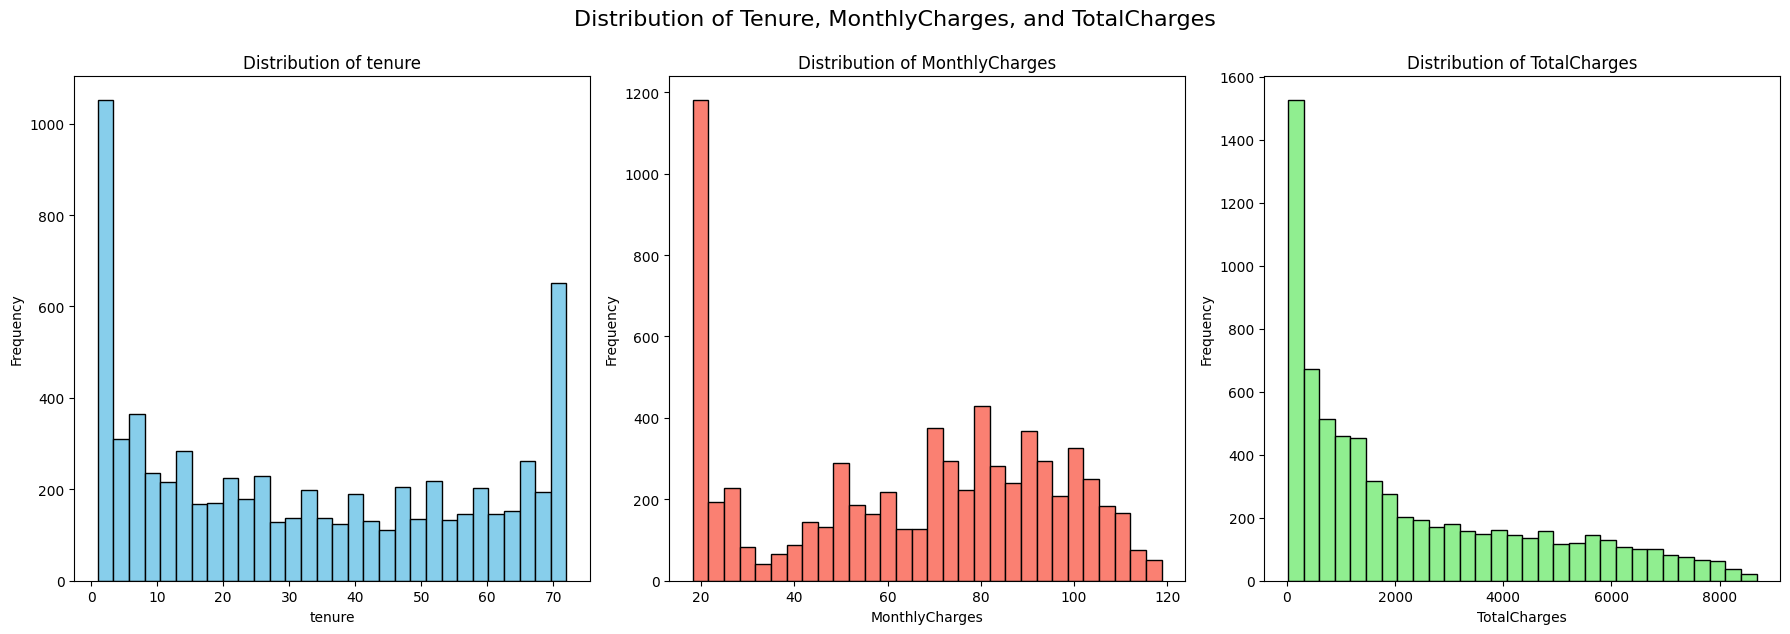

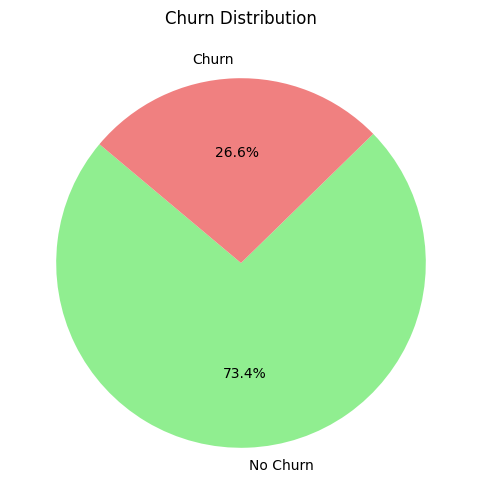

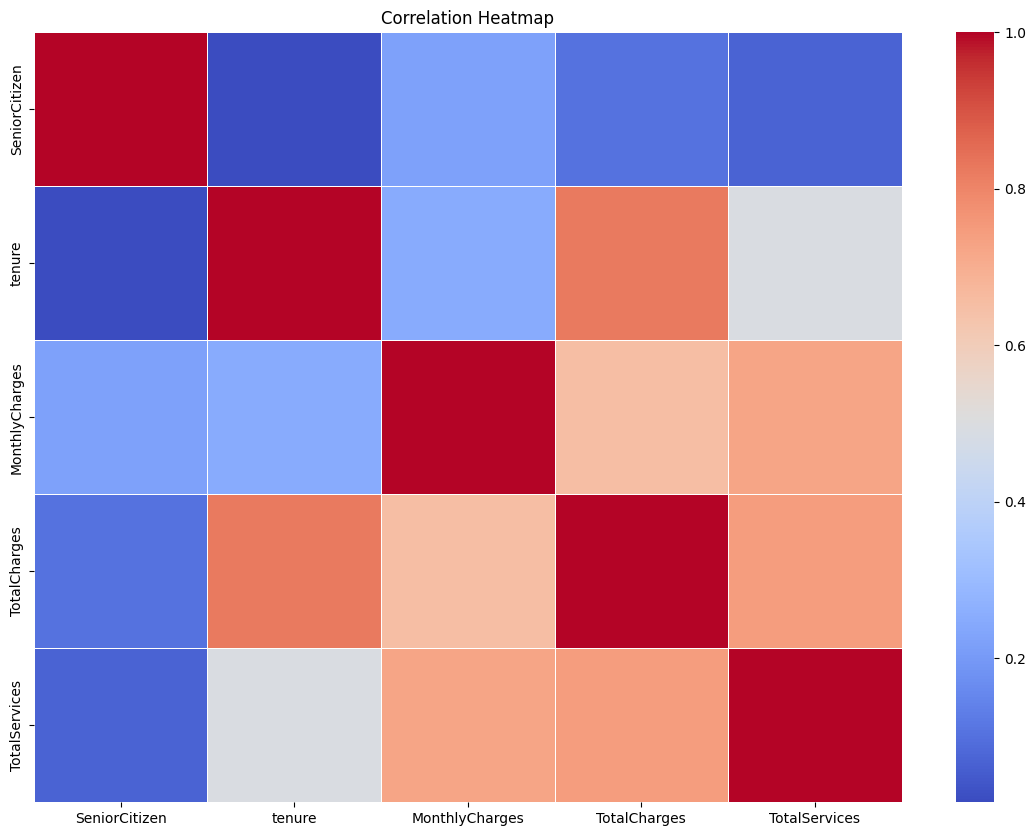

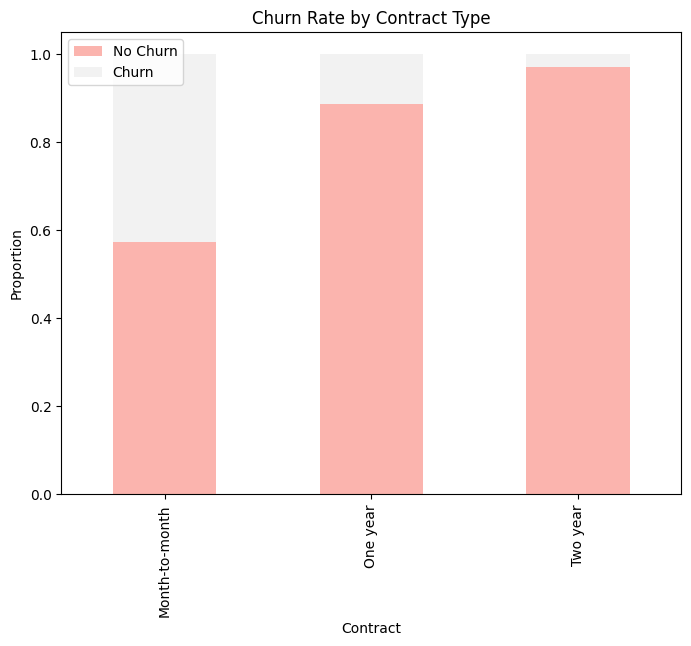

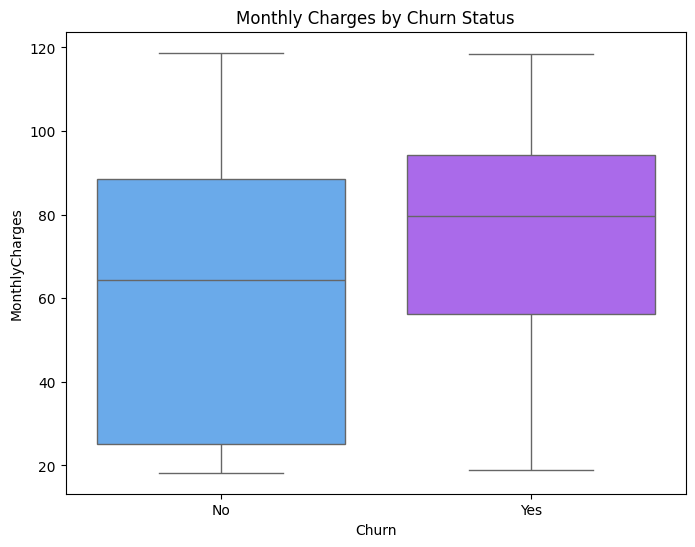


📊 LogisticRegression Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407


📊 RandomForest Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1033
           1       0.58      0.57      0.58       374

    accuracy                           0.78      1407
   macro avg       0.71      0.71      0.71      1407
weighted avg       0.78      0.78      0.78      1407


📊 XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1033
           1       0.55      0.54      0.54       374

    accuracy                           0.76      1407
   macr

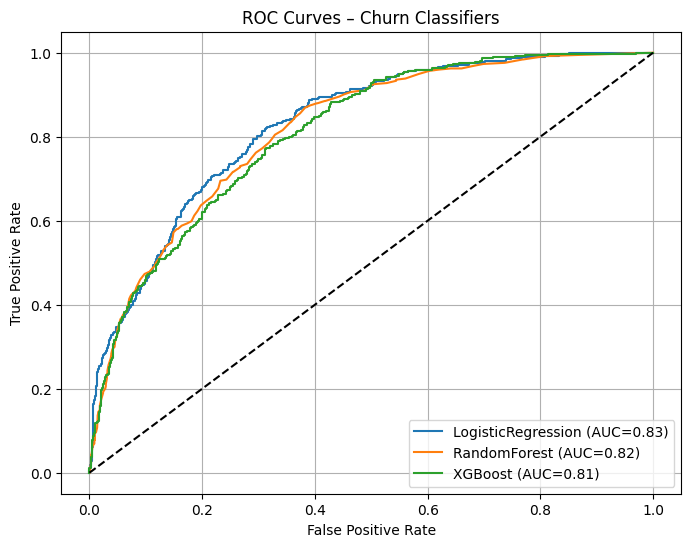

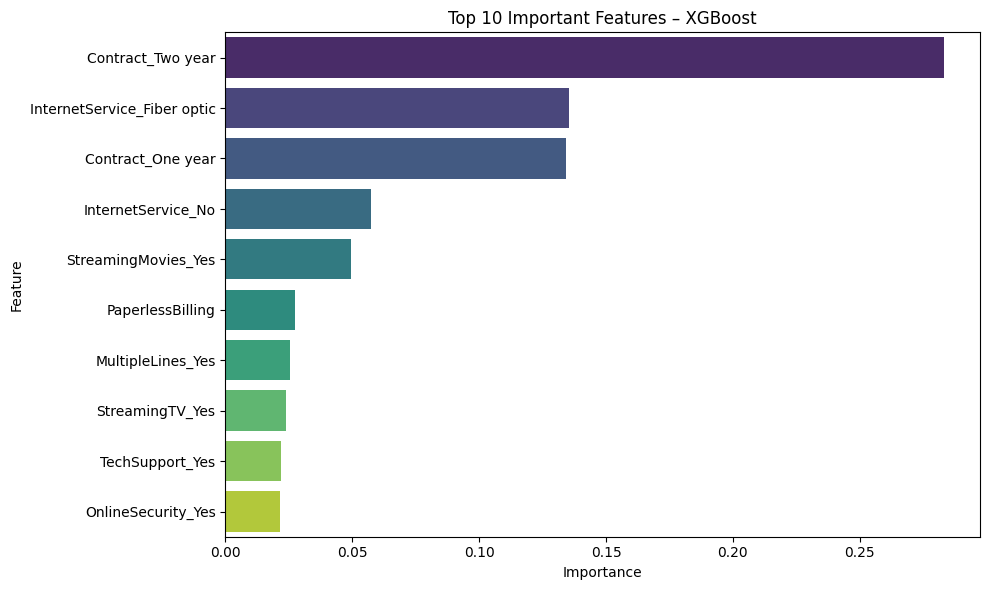

In [13]:
# 📌 Task 2: Customer Churn Prediction System – Future Interns

# Install required packages
!pip install -q imbalanced-learn xgboost

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# Load dataset
url = "https://raw.githubusercontent.com/MohElaghory/Telco-Customer-Churn/main/Dataset/Churn.csv"
df = pd.read_csv(url)

# Clean data
df.drop(['customerID'], axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Feature Engineering
df['tenure_group'] = pd.cut(df['tenure'], bins=[0,12,24,48,72], labels=['0-12','12-24','24-48','48+'])
services = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
df['TotalServices'] = df[services].apply(lambda x: x.eq('Yes').sum(), axis=1)

# --- 📊 Visual EDA ---

# 1. Countplots for categorical features
fig, ax = plt.subplots(5, 3, figsize=(18, 22))
fig.tight_layout(pad=4)

cols = [
    'gender', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

palette = sns.color_palette("Set2")

for i, col in enumerate(cols[:15]):
    row, col_idx = divmod(i, 3)
    plt.sca(ax[row, col_idx])
    sns.countplot(x=col, data=df, palette=palette)
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. Histograms for numeric features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
colors = ['skyblue', 'salmon', 'lightgreen']

plt.figure(figsize=(18, 6))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=30, color=colors[i], edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.suptitle("Distribution of Tenure, MonthlyCharges, and TotalCharges", fontsize=16, y=1.05)
plt.show()

# 3. Pie chart for Churn
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral'], startangle=140)
plt.title('Churn Distribution')
plt.show()

# 4. Correlation heatmap (numeric only)
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 5. Contract vs Churn (Stacked Bar Plot)
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index')
contract_churn.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Pastel1')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Proportion')
plt.legend(['No Churn', 'Churn'])
plt.show()

# 6. Boxplot: MonthlyCharges vs Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='cool')
plt.title('Monthly Charges by Churn Status')
plt.show()

# --- 🔄 Encoding + Modeling Pipeline ---

# Encode binary categorical columns
label_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() == 2]
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode remaining categorical features
df = pd.get_dummies(df, drop_first=True)

# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

# Train + Evaluate
results = {}
for name, model in models.items():
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {'model': model, 'auc': auc, 'y_pred': y_pred, 'y_proba': y_proba}
    print(f"\n📊 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC={res["auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Churn Classifiers')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance (XGBoost)
xgb_model = results['XGBoost']['model']
importances = xgb_model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title("Top 10 Important Features – XGBoost")
plt.tight_layout()
plt.show()
